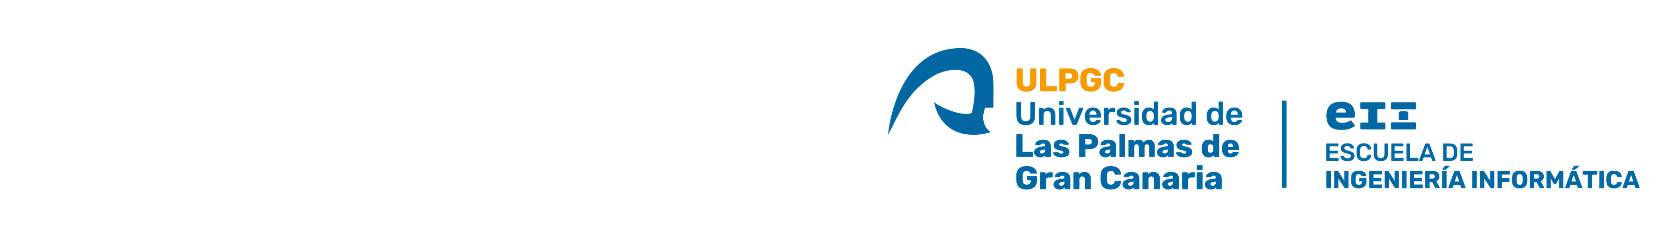




# **Fine tuning de un modelo con dataset tipo 'instruct'**

El entrenamiento "instruct" en los modelos de lenguaje grande (LLM) es una técnica especializada para afinar estos modelos con el objetivo de que respondan a indicaciones o instrucciones dadas por los usuarios de manera más efectiva y precisa.

### **Características principales del entrenamiento tipo "Instruct":**

1. **Entrenamiento con instrucciones específicas**:
   - En lugar de simplemente entrenar el modelo en texto general, el entrenamiento tipo "instruct" se basa en **pares de instrucciones y respuestas**.
   - Por ejemplo:
     - Instrucción: "Resume el siguiente texto en dos frases."
     - Respuesta esperada: Un resumen conciso que el modelo genera.
   - Este tipo de datos de entrenamiento le enseña al modelo a seguir comandos y a generar respuestas alineadas con la intención del usuario.

2. **Etiquetado humano o generación supervisada**:
   - En muchos casos, estos pares de instrucción-respuesta son generados por **anotadores humanos** que proporcionan respuestas de alta calidad a las instrucciones.
   - Alternativamente, se pueden generar automáticamente usando un modelo ya existente y luego verificar su calidad manualmente.


### **Cómo se realiza el entrenamiento "Instruct":**

1. **Creación del dataset de Instrucciones**:
   - Se crea un conjunto de datos que contiene ejemplos de instrucciones y respuestas deseadas.
   - Ejemplos típicos de instrucciones:
     - "Escribe un correo electrónico para invitar a alguien a un evento."
     - "Explica cómo funciona la inteligencia artificial en lenguaje simple."
   - Las respuestas deben ser redactadas para alinearse estrechamente con el propósito de la instrucción.

2. **Ajuste fino (Fine-tuning)**:
   - El modelo de lenguaje se ajusta finamente usando este conjunto de datos, de forma que se adapta a responder a estos comandos.
   - Se puede utilizar una técnica llamada **"Supervised Fine-Tuning" (SFT)** para ajustar el modelo con estos pares de datos.


In [ ]:
!pip install bitsandbytes
!pip install datasets
!pip install peft
!pip install wandb
!pip install trl

¡Ojo al ejecutar las siguientes celdas! Es posible que si da el error de que necesitamos la última versión de bitsandbytes u otros errores tengamos, simplemente, que reiniciar la sesión.

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType
from trl import SFTTrainer
import wandb
import os

os.environ['WANDB_NOTEBOOK_NAME'] = 'nb01-instruct.ipynb'

# Configuración del modelo y tokenizer
model_name = "/content/drive/MyDrive/Docencia/Máster/Notebooks/fine_tuned_model_autoregressive_merged"
tokenizer_name = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name, load_in_4bit=True, device_map='auto')

# Preparación del dataset
train_dataset = load_dataset('json', data_files='/content/drive/MyDrive/Docencia/Máster/Notebooks/data/questions_train.jsonl', split="train")


def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])


wandb.init(
    project='LLM_training',
    name=model_name + '_autoregressive_instruct_fine_tuning'
)


# Configuración de LoRA
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,  # rango de LoRA
    lora_alpha=16,  # hiperparámetro de LoRA
    lora_dropout=0.1,  # dropout de LoRA
    target_modules=['q_proj', 'v_proj', 'k_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']  # módulos objetivo para aplicar LoRA
)

model = get_peft_model(model, lora_config)

# Configuración de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=2,
    save_steps=10_000,
    save_total_limit=2,
    logging_steps=100,
    learning_rate=1e-4,
    fp16=True,
    evaluation_strategy="no",
    eval_steps=10_000,
    report_to="wandb"
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    # eval_dataset=valid_dataset_mapped,
    # dataset_text_field="text",
    max_seq_length=64,
    tokenizer=tokenizer,
    args=training_args,
    # compute_metrics=compute_metrics_fn,
    packing=True,
    data_collator=data_collator,
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find nb01-instruct.ipynb.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, packing. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:212: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will override the one in t

In [3]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss
100,0.711200
200,0.159200


TrainOutput(global_step=250, training_loss=0.3757964725494385, metrics={'train_runtime': 114.211, 'train_samples_per_second': 4.378, 'train_steps_per_second': 2.189, 'total_flos': 1369273270272000.0, 'train_loss': 0.3757964725494385, 'epoch': 10.0})

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Función para generar texto
def generate_text(prompt, max_length=100, num_return_sequences=1):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.01
    )
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

In [6]:
# Ejemplo de uso
prompt = "<s>[INST] ¿Cuál es el teléfono de Noa? [/INST]"
generated_texts = generate_text(prompt, max_length=45, num_return_sequences=1)

# Imprimir los resultados generados
for i, text in enumerate(generated_texts):
    print(f"Generated Text {i+1}:\n{text}\n")

Generated Text 1:
[INST] ¿Cuál es el teléfono de Noa? [/INST] El teléfono de Noa es el 928815018. 

